In [1]:
import pymysql
import pandas as pd
conn = pymysql.connect(host='localhost',
                       port=3306,
                       user='root',
                       password='20010111',
                       db='xlnews',
                       charset='utf8',
                       use_unicode=True)


sql = 'select * from warehouse_news'
df = pd.read_sql(sql, con=conn)
print(df.head())

df.to_csv("data.csv")
conn.close()

                                                link  \
0  https://finance.sina.com.cn/2023-04-07/doc-imy...   
1  https://finance.sina.com.cn/2023-04-07/doc-imy...   
2  https://finance.sina.com.cn/2023-04-07/doc-imy...   
3  https://finance.sina.com.cn/2023-04-07/doc-imy...   
4  https://finance.sina.com.cn/2023-04-08/doc-imy...   

                                         title                 date source  \
0                  四川德阳警方通报网传中国电科加班事件：散布谣言者被行拘  2023-04-07 20:46:36   澎湃新闻   
1                       中华人民共和国和法兰西共和国联合声明（全文）  2023-04-07 21:02:25    新华社   
2          中电科员工“怒怼领导”？刚刚，警方通报：聊天记录系捏造，已拘留陈某龙！  2023-04-07 21:18:15   市场资讯   
3  国常会：要想方设法稳住对发达经济体出口，引导企业深入开拓发展中国家市场和东盟等区域市场  2023-04-07 20:21:00    央视网   
4      刚刚！华为云AI首席科学家发声：这是人工智能新爆点！还介绍“华为盘古”最新进展  2023-04-08 15:20:03   市场资讯   

                                             article  emo  
0  　　据“平安德阳经开区”微博通报，经初查，陈某龙目前居住在德阳经开区，系网上发布不实信息者，...  未处理  
1  　　新华社北京4月7日电　　中华人民共和国和法兰西共和国联合声明　　应中华人民共和国主席习近...  未处理  
2  　　来源：证券时报　　

In [10]:
#定义下游任务模型
from transformers import BertModel
import torch

#加载预训练模型
pretrained = BertModel.from_pretrained(r'D:\86136\新建文件夹\WeChat Files\guoyantong1397\FileStorage\File\2023-04\Archive\xlNews\bert\bert-base-chinese')
pretrained = pretrained
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = torch.nn.Linear(768, 3)  # 单层网络模型，只包括了一个fc的神经网络 3是分为三类

    def forward(self, input_ids, attention_mask, token_type_ids):
        with torch.no_grad():
            out = pretrained(input_ids=input_ids,   # 先拿预训练模型来做一个计算，抽取数据当中的特征
                       attention_mask=attention_mask,
                       token_type_ids=token_type_ids)

        # 把抽取出来的特征放到全连接网络中运算，且特征的结果只需要第0个词的特征(跟bert模型的设计方式有关。对句子的情感分类，只需要拿特征中的第0个词来进行分类就可以了)
        out = self.fc(out.last_hidden_state[:, 0])   # torch.Size([16, 768])

        # 将softmax函数应用于一个n维输入张量，对其进行缩放，使n维输出张量的元素位于[0,1]范围内，总和为1
        out = out.softmax(dim=1)

        return out

Some weights of the model checkpoint at D:\86136\新建文件夹\WeChat Files\guoyantong1397\FileStorage\File\2023-04\Archive\xlNews\bert\bert-base-chinese were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [1]:
import torch._utils
try:
    torch._utils._rebuild_tensor_v2
except AttributeError:
    def _rebuild_tensor_v2(storage, storage_offset, size, stride, requires_grad, backward_hooks):
        tensor = torch._utils._rebuild_tensor(storage, storage_offset, size, stride)
        tensor.requires_grad = requires_grad
        tensor._backward_hooks = backward_hooks
        return tensor
    torch._utils._rebuild_tensor_v2 = _rebuild_tensor_v2

In [9]:
from transformers import BertTokenizer


#加载字典和分词工具，即tokenizer

token = BertTokenizer.from_pretrained('bert-base-chinese')

In [10]:
torch.__version__

'1.10.2+cpu'

In [24]:
import numpy as np
import random
def set_seed(seed):
    """for reproducibility
    :param seed:
    :return:
    """
    np.random.seed(seed)
    random.seed(seed)

    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [29]:


import torch

set_seed(1)
 # 要跟预训练模型相匹配
the_model = Model()
m_state_dict = torch.load(r"D:\86136\新建文件夹\WeChat Files\guoyantong1397\FileStorage\File\2023-04\Archive\xlNews\bert\model.pt",map_location=torch.device('cpu'))
the_model.load_state_dict(m_state_dict)


res = token.encode_plus("",
                               truncag='max_length',   # 一律补0到max_length长度
                               max_letion=True,   # 当句子长度大于max_length时，截断
                               paddinngth='max_length',
                        max_length=512,
                                # model_max_length=500,
                               return_tensors='pt',   # 返回pytorch类型的tensor
                               return_length=True)   # 返回length，标识长度
the_model.eval()

with torch.no_grad():
    out = the_model(input_ids=res.input_ids,
                attention_mask=res.attention_mask,
                token_type_ids=res.token_type_ids)

    out = out.argmax(dim=1)
    print(out)

Keyword arguments {'truncag': 'max_length', 'max_letion': True, 'paddinngth': 'max_length'} not recognized.


tensor([1])


In [32]:
def pred(text):
    res = token.encode_plus(text,
                               truncag='max_length',   # 一律补0到max_length长度
                               max_letion=True,   # 当句子长度大于max_length时，截断
                               paddinngth='max_length',
                                max_length=500,
                                # model_max_length=500,
                               return_tensors='pt',   # 返回pytorch类型的tensor
                               return_length=True)   # 返回length，标识长度
    the_model.eval()

    with torch.no_grad():
        out = the_model(input_ids=res.input_ids,
                    attention_mask=res.attention_mask,
                    token_type_ids=res.token_type_ids)

        out = out.argmax(dim=1)
        return out


In [57]:
def res(out):
    if out==0:
        return "消极"
    elif out==1:
        return "中立"
    else:
        return "积极"


In [58]:
text='啊啦啦啦啦啦啦啦啦啦啦啦啦'
out=pred(text)
print(res(out))


Keyword arguments {'truncag': 'max_length', 'max_letion': True, 'paddinngth': 'max_length'} not recognized.


中立


In [33]:
import pandas as pd
df_news=pd.read_csv(r"D:\86136\新建文件夹\WeChat Files\guoyantong1397\FileStorage\File\2023-04\Archive\data.csv").iloc[:,5:7]
df_news.columns=['ocr','label']
df_news.label = 0
df_news.dropna(axis=0,inplace=True)
df_news.isnull().sum()
df_news


,ocr,label
0,据“平安德阳经开区”微博通报，经初查，陈某龙目前居住在德阳经开区，系网上发布不实信息者，...,0
1,新华社北京4月7日电 中华人民共和国和法兰西共和国联合声明 应中华人民共和国主席习近...,0
2,来源：证券时报 7日晚间，警方通报网传中电科加班事件调查结果，通报全文如下： 据人民...,0
3,国务院总理李强4月7日主持召开国务院常务会议，研究推动外贸稳规模优结构的政策措施，审议通...,0
4,来源：e公司 4月8日，人工智能大模型技术高峰论坛在杭州萧山开幕。 证券时报·e公司...,0
...,...,...
303,瑞士检察官周日对瑞银集团收购瑞士信贷一事展开调查。 该国联邦检察官正在调查瑞士信贷和瑞...,0
304,来源：国际金融报 总裁王青山被“叫出会场”未归？浙商证券称，总裁目前在休假，其他事情暂...,0
305,转自：中国证券报 日前，保险业首只产权类Pre-REITs专题基金成功签约，规模约50...,0
306,转自：中国证券报 塔牌集团4月7日晚间发布2023年一季度业绩预告。2023年一季度，...,0


In [39]:
from tqdm.auto import tqdm


In [54]:
progress_bar = tqdm(range(len(df_news)))
for i in range(len(df_news)):
    out=pred(df_news.ocr.iloc[i])
    df_news.label.iloc[i]=out.numpy()[0]
    progress_bar.update(1)

  0%|          | 0/305 [00:00<?, ?it/s]

Keyword arguments {'truncag': 'max_length', 'max_letion': True, 'paddinngth': 'max_length'} not recognized.
C:\Users\86136\Anaconda3\envs\DjangoPath\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
Keyword arguments {'truncag': 'max_length', 'max_letion': True, 'paddinngth': 'max_length'} not recognized.
Keyword arguments {'truncag': 'max_length', 'max_letion': True, 'paddinngth': 'max_length'} not recognized.
Keyword arguments {'truncag': 'max_length', 'max_letion': True, 'paddinngth': 'max_length'} not recognized.
Keyword arguments {'truncag': 'max_length', 'max_letion': True, 'paddinngth': 'max_length'} not recognized.
Keyword arguments {'truncag': 'max_length', 'max_letion': True, 'paddinngth': 'max_length'} not 

In [55]:
df_news.label.value_counts()


1    288
2     13
0      4
Name: label, dtype: int64

In [3]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['font.sans-serif'] = ['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号

C:\Users\86136\Anaconda3\envs\DjangoPath\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
C:\Users\86136\Anaconda3\envs\DjangoPath\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
C:\Users\86136\Anaconda3\envs\DjangoPath\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
C:\Users\86136\Anaconda3\envs\DjangoPath\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
C:\Users\86136\Anaconda3\envs\DjangoPath\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
C:\Users\86136\Anaconda3\envs\DjangoPath\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 39044 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\86136\Anaconda3\envs\DjangoPath\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 279

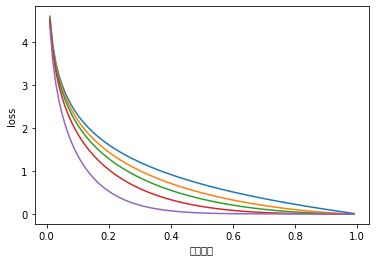

In [5]:
x = np.arange(0, 1, 0.01)
plt.rcParams['font.family'] = ['Droid Sans Fallback']# 用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False # 用来正常显示负号
plt.xlabel('预测概率')
plt.ylabel('loss')
plt.title("")
for i in [0,0.5,1,2,5]:
    y = -(1-x)**i*np.log(x)
    plt.plot(x, y)
plt.show()
